
RandomForest
              precision    recall  f1-score   support

       False       0.55      0.67      0.60        33
        True       0.86      0.78      0.82        83

    accuracy                           0.75       116
   macro avg       0.70      0.72      0.71       116
weighted avg       0.77      0.75      0.76       116

AUC: 0.8660094925155166


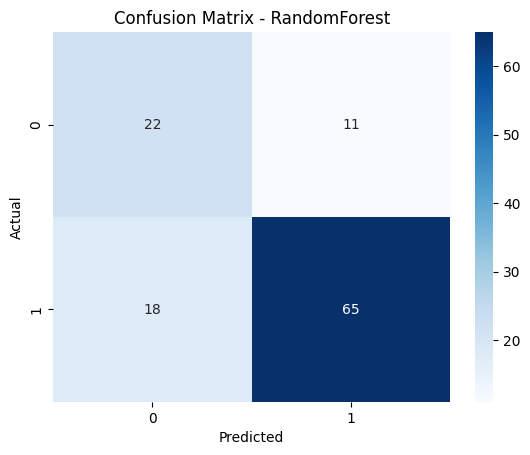


HistGradientBoosting
              precision    recall  f1-score   support

       False       0.59      0.73      0.65        33
        True       0.88      0.80      0.84        83

    accuracy                           0.78       116
   macro avg       0.73      0.76      0.74       116
weighted avg       0.80      0.78      0.78       116

AUC: 0.8703906535231837


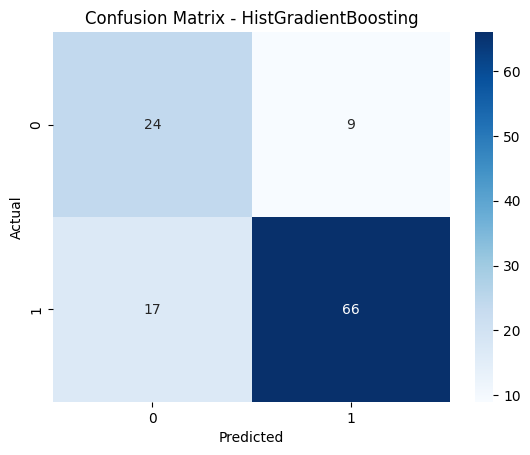


LogisticRegression
              precision    recall  f1-score   support

       False       0.62      0.79      0.69        33
        True       0.91      0.81      0.85        83

    accuracy                           0.80       116
   macro avg       0.76      0.80      0.77       116
weighted avg       0.82      0.80      0.81       116

AUC: 0.8922964585615187


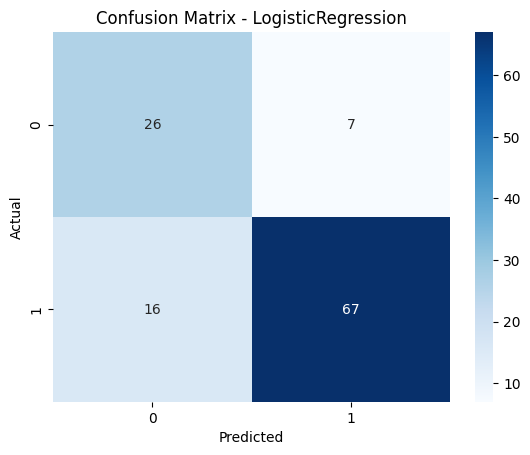

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Load data
df = pd.read_parquet("../../data/processed/model_ready.parquet")
target = "incident_occurred"

features = [
    "ride_type_simplified", "ride_incident_count", "duration_min",
    "age", "gender", "simulated_medical_condition", "first_time_visitor",
    "season", "is_weekend",
    "temperature_max", "precipitation_sum"
]

df_model = pd.get_dummies(df[features + [target]], drop_first=True)

# 2. Split data
X = df_model.drop(columns=target)
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Define models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

results = {}

# 4. Train and evaluate
for name, model in models.items():
    print(f"\n{name}")
    X_train_clean = X_train.dropna()
    y_train_clean = y_train.loc[X_train_clean.index]
    X_test_clean = X_test.dropna()
    y_test_clean = y_test.loc[X_test_clean.index]

    model.fit(X_train_clean, y_train_clean)
    y_pred = model.predict(X_test_clean)
    y_prob = model.predict_proba(X_test_clean)[:, 1] if hasattr(model, "predict_proba") else None

    print(classification_report(y_test_clean, y_pred))
    print("AUC:", roc_auc_score(y_test_clean, y_prob) if y_prob is not None else "n/a")

    results[name] = {
        "model": model,
        "y_true": y_test_clean,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test_clean, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
